# Importing Libraries

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn
from sklearn import neighbors
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle

# Importing files

In [4]:
training = "master.csv"
training1 = "lec_tues_4.csv"
training2 = "lab_mon_5.csv"
training3 = "tut_wed_4.csv"
training4 = "lab_fri_4.csv"
training5 = "tut_fri_4.csv"
training6 = "sun_4.csv"
training7 = "lab_wed_5.csv"

path = "C:\\Users\\ieliz\\Documents\\2021\\FYP\\Stress_Detection_FYP\\python_scripts\\"

In [5]:
os.chdir(path)
print(os.getcwd())
df = pd.read_csv(training)
df1 = pd.read_csv(training1)
df2 = pd.read_csv(training2)
df3 = pd.read_csv(training3)
df4 = pd.read_csv(training4)
df5 = pd.read_csv(training5)
df6 = pd.read_csv(training6)
df7 = pd.read_csv(training7)

df = df.append(df1, ignore_index=True)
df = df.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df = df.append(df4, ignore_index=True)
df = df.append(df5, ignore_index=True)
df = df.append(df6, ignore_index=True)
df = df.append(df7, ignore_index=True)

df["Time (hr:min:sec)"] = pd.to_datetime(df["Time (hr:min:sec)"], format="%H:%M:%S").dt.time

C:\Users\ieliz\Documents\2021\FYP\Stress_Detection_FYP\python_scripts


In [6]:
# TESTING DATA
test = "lab_wed_4.csv"
test1 = "lab_mon_5.csv"

df_test = pd.read_csv(test)
df_test1 = pd.read_csv(test1)

df_test = df_test.append(df_test1, ignore_index=True)

df_test["Time (hr:min:sec)"] = pd.to_datetime(df_test["Time (hr:min:sec)"], format="%H:%M:%S").dt.time

In [7]:
df

,Time (hr:min:sec),Time (s),GSR,Resistance,Conductance (uS),Heart_Rate,Section,Stressed
0,12:00:01,1,225,51358.88502,19.470828,68,RelaxM4_,2
1,12:00:02,2,224,51111.11111,19.565217,68,RelaxM4_,2
2,12:00:03,3,224,51111.11111,19.565217,69,RelaxM4_,2
3,12:00:04,4,225,51358.88502,19.470828,68,RelaxM4_,2
4,12:00:05,5,224,51111.11111,19.565217,68,RelaxM4_,2
...,...,...,...,...,...,...,...,...
52491,11:31:49,3597,439,260547.94520,3.838065,63,wed_lab_5_3,2
52492,11:31:50,3598,439,260547.94520,3.838065,63,wed_lab_5_3,2
52493,11:31:51,3599,443,276811.59420,3.612565,63,wed_lab_5_3,2
52494,11:31:52,3600,444,281176.47060,3.556485,63,wed_lab_5_3,2


In [8]:
df["Section"].unique()

array(['RelaxM4_', 'LabM4_1_', 'LabM4_2_', 'LabM4_3_', 'lec_tues_0',
       'lab_mon_5', 'tut_wed_4_0', 'tut_wed_4_1', 'lab_fri4_1',
       'tut_fri4_1', 'tut_fri4_2', 'sun_data_1', 'sun_data',
       'wed_lab_5_1', 'wed_lab_5_2', 'wed_lab_5_3'], dtype=object)

# Calculating Conductance

In [9]:
# df["Conductance (uS)"] = 1*10**6/df["Resistance"]

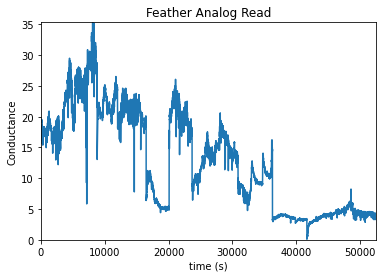

In [10]:
fig, ax = plt.subplots()
ax.set_xlim((0, len(df)))
ax.set_ylim((0, max(df["Conductance (uS)"])))
ax.set_title('Feather Analog Read')
ax.set_xlabel("time (s)")
ax.set_ylabel("Conductance")
ax.plot(df.index, df["Conductance (uS)"])

# Pre-processing Data and Feature Extraction
## Separating into sections

In [11]:
labels = []
df["Section_labels"] = None

for i, g in df.groupby([(df.Stressed != df.Stressed.shift()).cumsum()]):
    label = g.Stressed.tolist()[0]
    labels.append(label)    
    df.at[g.index[0]: g.index[-1], "Section_labels"] = str(i) + '_' + str(label)

unique_sections = df["Section_labels"].unique()
unique_sections_num = df["Section_labels"].nunique()
print(unique_sections, unique_sections_num)
print(labels)

['1_2' '2_6' '3_4' '4_6' '5_4' '6_6' '7_4' '8_6' '9_7' '10_6' '11_4'
 '12_6' '13_4' '14_5' '15_3' '16_5' '17_2' '18_4' '19_2' '20_4' '21_2'
 '22_4' '23_2' '24_5' '25_2' '26_4' '27_2' '28_4' '29_2' '30_4' '31_7'
 '32_3' '33_4' '34_7' '35_4' '36_5' '37_4' '38_3' '39_4' '40_5' '41_4'
 '42_3' '43_4' '44_3' '45_4' '46_3' '47_5' '48_3' '49_5' '50_4' '51_5'
 '52_3' '53_7' '54_3' '55_7' '56_3' '57_5' '58_4' '59_5' '60_3' '61_6'
 '62_2' '63_4' '64_3' '65_4' '66_5' '67_3' '68_5' '69_4' '70_5' '71_6'
 '72_4' '73_5' '74_4' '75_6' '76_4' '77_5' '78_4' '79_5' '80_4' '81_5'
 '82_7' '83_5' '84_3' '85_4' '86_5' '87_3' '88_6' '89_3' '90_6' '91_5'
 '92_2'] 92
[2, 6, 4, 6, 4, 6, 4, 6, 7, 6, 4, 6, 4, 5, 3, 5, 2, 4, 2, 4, 2, 4, 2, 5, 2, 4, 2, 4, 2, 4, 7, 3, 4, 7, 4, 5, 4, 3, 4, 5, 4, 3, 4, 3, 4, 3, 5, 3, 5, 4, 5, 3, 7, 3, 7, 3, 5, 4, 5, 3, 6, 2, 4, 3, 4, 5, 3, 5, 4, 5, 6, 4, 5, 4, 6, 4, 5, 4, 5, 4, 5, 7, 5, 3, 4, 5, 3, 6, 3, 6, 5, 2]


## Moving average filter

In [12]:
def moving_ave_filter(df):
    df["Conductance (uS)"] = df["Conductance (uS)"].rolling(5).mean()  #1 second moving average filter
    df["Heart_Rate"] = df["Heart_Rate"].rolling(5).mean()  #1 second moving average filter
    df = df.dropna()
    return df

In [13]:
df = df.groupby(df["Section_labels"]).apply(moving_ave_filter)    

In [14]:
df

Time (hr:min:sec)  Time (s)  GSR   Resistance  \
Section_labels                                                      
10_6           8404          15:00:05      8405  124  32783.50515   
               8405          15:00:06      8406  123  32647.81491   
               8406          15:00:07      8407  123  32647.81491   
               8407          15:00:08      8408  118  31979.69543   
               8408          15:00:09      8409  119  32111.95929   
...                               ...       ...  ...          ...   
9_7            8395          14:59:56      8396  120  32244.89796   
               8396          14:59:57      8397  121  32378.51662   
               8397          14:59:58      8398  121  32378.51662   
               8398          14:59:59      8399  121  32378.51662   
               8399          15:00:00      8400  122  32512.82051   

                     Conductance (uS)  Heart_Rate   Section  Stressed  \
Section_labels                                                          
10_6           8404         30.528500        71.8  LabM4_3_         6   
               8405         30.553855        71.4  LabM4_3_         6   
               8406         30.553855        70.6  LabM4_3_         6   
               8407         30.707195        71.6  LabM4_3_         6   
               8408         30.834775        73.2  LabM4_3_         6   
...                               ...         ...       ...       ...   
9_7            8395         30.987305        71.8  LabM4_2_         7   
               8396         31.012820        72.8  LabM4_2_         7   
               8397         31.012820        72.6  LabM4_2_         7   
               8398         30.961547        72.8  LabM4_2_         7   
               8399         30.884757        72.0  LabM4_2_         7   

                    Section_labels  
Section_labels                      
10_6           8404           10_6  
               8405           10_6  
               8406           10_6  
               8407           10_6  
               8408           10_6  
...                            ...  
9_7            8395            9_7  
               8396            9_7  
               8397            9_7  
               8398            9_7  
               8399            9_7  

[52128 rows x 9 columns]

## Min-Max Normalisation

In [15]:
def min_max_normalisation(df):
    min_val_gsr = min(df['Conductance (uS)'])
    max_val_gsr = max(df['Conductance (uS)'])
    scaling_gsr = max_val_gsr-min_val_gsr
    df.loc[:, 'Normalised_GSR'] = (df.loc[:, 'Conductance (uS)']- min_val_gsr)/scaling_gsr 
    
    min_val_hr = min(df["Heart_Rate"])
    max_val_hr = max(df["Heart_Rate"])
    scaling_hr = max_val_hr-min_val_hr
    df.loc[:, "Normalised_HR"] = (df.loc[:, "Heart_Rate"]- min_val_hr)/scaling_hr
    df = df.dropna()
    return df

In [16]:
df = df.groupby(df["Section_labels"]).apply(min_max_normalisation)

In [17]:
df

Time (hr:min:sec)  Time (s)  GSR   Resistance  \
Section_labels                                                      
10_6           8404          15:00:05      8405  124  32783.50515   
               8405          15:00:06      8406  123  32647.81491   
               8406          15:00:07      8407  123  32647.81491   
               8407          15:00:08      8408  118  31979.69543   
               8408          15:00:09      8409  119  32111.95929   
...                               ...       ...  ...          ...   
9_7            8395          14:59:56      8396  120  32244.89796   
               8396          14:59:57      8397  121  32378.51662   
               8397          14:59:58      8398  121  32378.51662   
               8398          14:59:59      8399  121  32378.51662   
               8399          15:00:00      8400  122  32512.82051   

                     Conductance (uS)  Heart_Rate   Section  Stressed  \
Section_labels                                                          
10_6           8404         30.528500        71.8  LabM4_3_         6   
               8405         30.553855        71.4  LabM4_3_         6   
               8406         30.553855        70.6  LabM4_3_         6   
               8407         30.707195        71.6  LabM4_3_         6   
               8408         30.834775        73.2  LabM4_3_         6   
...                               ...         ...       ...       ...   
9_7            8395         30.987305        71.8  LabM4_2_         7   
               8396         31.012820        72.8  LabM4_2_         7   
               8397         31.012820        72.6  LabM4_2_         7   
               8398         30.961547        72.8  LabM4_2_         7   
               8399         30.884757        72.0  LabM4_2_         7   

                    Section_labels  Normalised_GSR  Normalised_HR  
Section_labels                                                     
10_6           8404           10_6        0.934668       0.296482  
               8405           10_6        0.936068       0.286432  
               8406           10_6        0.936068       0.266332  
               8407           10_6        0.944537       0.291457  
               8408           10_6        0.951583       0.331658  
...                            ...             ...            ...  
9_7            8395            9_7        0.812653       0.208494  
               8396            9_7        0.814040       0.227799  
               8397            9_7        0.814040       0.223938  
               8398            9_7        0.811253       0.227799  
               8399            9_7        0.807078       0.212355  

[52128 rows x 11 columns]

## Extract Phasic components

## Applying low pass filter

In [18]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
def low_pass(df):
    df["LPF_GSR"] = butter_lowpass_filter(df["Normalised_GSR"], cutoff, fs, order)
    df["LPF_HR"] = butter_lowpass_filter(df["Normalised_HR"], cutoff, fs, order)
    df = df.dropna()
    return df

## Identifying onset and offset of stressor
## Find peaks and maximum amplitude
## Find average

In [20]:
# For each section of data
# Label as stressed/not stressed
# Find peak, maximum amplitude and average GSR
# Training data: peak, max and average GSR + label

# Filter requirements
order = 6
fs = 60      # sample rate, Hz
cutoff = 20  # desired cutoff frequency of the filter, Hz

In [21]:
# Low pass filter
df = df.groupby(df["Section_labels"]).apply(low_pass)

In [22]:
df

Time (hr:min:sec)  Time (s)  GSR   Resistance  \
Section_labels                                                      
10_6           8404          15:00:05      8405  124  32783.50515   
               8405          15:00:06      8406  123  32647.81491   
               8406          15:00:07      8407  123  32647.81491   
               8407          15:00:08      8408  118  31979.69543   
               8408          15:00:09      8409  119  32111.95929   
...                               ...       ...  ...          ...   
9_7            8395          14:59:56      8396  120  32244.89796   
               8396          14:59:57      8397  121  32378.51662   
               8397          14:59:58      8398  121  32378.51662   
               8398          14:59:59      8399  121  32378.51662   
               8399          15:00:00      8400  122  32512.82051   

                     Conductance (uS)  Heart_Rate   Section  Stressed  \
Section_labels                                                          
10_6           8404         30.528500        71.8  LabM4_3_         6   
               8405         30.553855        71.4  LabM4_3_         6   
               8406         30.553855        70.6  LabM4_3_         6   
               8407         30.707195        71.6  LabM4_3_         6   
               8408         30.834775        73.2  LabM4_3_         6   
...                               ...         ...       ...       ...   
9_7            8395         30.987305        71.8  LabM4_2_         7   
               8396         31.012820        72.8  LabM4_2_         7   
               8397         31.012820        72.6  LabM4_2_         7   
               8398         30.961547        72.8  LabM4_2_         7   
               8399         30.884757        72.0  LabM4_2_         7   

                    Section_labels  Normalised_GSR  Normalised_HR   LPF_GSR  \
Section_labels                                                                
10_6           8404           10_6        0.934668       0.296482  0.108780   
               8405           10_6        0.936068       0.286432  0.546062   
               8406           10_6        0.936068       0.266332  1.067200   
               8407           10_6        0.944537       0.291457  1.068780   
               8408           10_6        0.951583       0.331658  0.826187   
...                            ...             ...            ...       ...   
9_7            8395            9_7        0.812653       0.208494  0.810046   
               8396            9_7        0.814040       0.227799  0.812731   
               8397            9_7        0.814040       0.223938  0.813409   
               8398            9_7        0.811253       0.227799  0.814076   
               8399            9_7        0.807078       0.212355  0.812158   

                       LPF_HR  
Section_labels                 
10_6           8404  0.034506  
               8405  0.171993  
               8406  0.330054  
               8407  0.317922  
               8408  0.244692  
...                       ...  
9_7            8395  0.186201  
               8396  0.206023  
               8397  0.223070  
               8398  0.229878  
               8399  0.224303  

[52128 rows x 13 columns]

In [23]:
# Finding max, min and average test values
GSR_peaks = []
GSR_max_peaks = []
GSR_min_peaks = []
GSR_num_peaks = []
GSR_average = []

HR_peaks = []
HR_max_peaks = []
HR_min_peaks = []
HR_num_peaks = []
HR_average = []

0 1.0 0.0659340659340659 1.0 0.2915330166789334 0.446166709544636 0.5986505466421916 2
1 1.0 0.207547169811321 1.0 0.05999110761811916 0.5071710861805201 0.58879607045708 6
2 1.0 0.011560693641618252 1.0 0.29478247990518974 0.372106751937031 0.7219675594417493 4
3 1.0 0.06060606060606061 0.9952436376843736 0.36251985400736125 0.4449926090169992 0.6491129793685437 6
4 1.0 0.12444444444444432 1.0 0.2929431543951512 0.3105493133583021 0.7352006028716097 4
5 1.0 0.12650602409638562 1.0 0.07879732824962334 0.4157585052572591 0.41298692336445914 6
6 1.0 0.6557377049180326 1.0 0.25740348036054156 0.564174330267893 0.5117479310732972 4
7 1.0 0.08713692946058096 1.0 0.03878317143669799 0.28869533788548285 0.44585999748862876 6
8 1.0 0.05791505791505792 1.0 0.19962257779761336 0.29357802105299324 0.5548577836470729 7
9 1.0 0.06030150753768841 1.0 0.18651117121172262 0.3530737259785962 0.5256353719692481 6
10 1.0 0.10121457489878541 1.0 0.008349153183697281 0.3835095698510662 0.42094064827680455 

ValueError: max() arg is an empty sequence

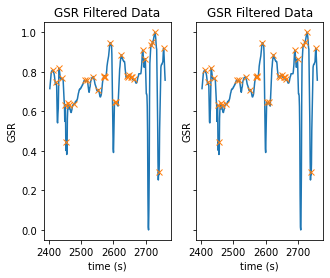

In [36]:
for i in range(unique_sections_num):
    grouped = df.groupby(df["Section_labels"])
    section = grouped.get_group(unique_sections[i])
    time = section['Time (s)'].to_numpy()
    HR_data = section["Normalised_HR"].to_numpy()
    GSR_data = section["Normalised_GSR"].to_numpy()
    #print('time', time, data)
    
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_title('HR Filtered Data')
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("HR")
    ax1.plot(time, HR_data)
    ax2.set_title('GSR Filtered Data')
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("GSR")
    ax2.plot(time, GSR_data)
    
    curr_peaks_ind, _ = find_peaks(HR_data)
    curr_peaks = HR_data[curr_peaks_ind]
    HR_max_peak = max(curr_peaks)
    HR_min_peak = min(curr_peaks)

    ax1.plot(time[curr_peaks_ind],curr_peaks, "x")
    
    HR_peaks.append(curr_peaks)
    HR_num_peaks.append(len(curr_peaks))
    HR_max_peaks.append(HR_max_peak)
    HR_min_peaks.append(HR_min_peak)
    
    HR_ave = np.mean(HR_data)
    HR_average.append(HR_ave)
    
    curr_peaks_ind, _ = find_peaks(GSR_data)
    curr_peaks = GSR_data[curr_peaks_ind]
    GSR_max_peak = max(curr_peaks)
    GSR_min_peak = min(curr_peaks)

    ax2.plot(time[curr_peaks_ind],curr_peaks, "x")
    
    GSR_peaks.append(curr_peaks)
    GSR_num_peaks.append(len(curr_peaks))
    GSR_max_peaks.append(GSR_max_peak)
    GSR_min_peaks.append(GSR_min_peak)
    
    GSR_ave = np.mean(GSR_data)
    GSR_average.append(GSR_ave)
    
    print(i, HR_max_peak, HR_min_peak, GSR_max_peak, GSR_min_peak, HR_ave, GSR_ave, labels[i])

In [26]:
stress_df = pd.DataFrame()
stress_df['HR_Max'] = pd.Series(HR_max_peaks)
stress_df['GSR_Max'] = pd.Series(GSR_max_peaks)
stress_df['HR_Min'] = pd.Series(HR_min_peaks)
stress_df['GSR_Min'] = pd.Series(GSR_min_peaks)
stress_df['HR_Ave'] = pd.Series(HR_average)
stress_df['GSR_Ave'] = pd.Series(GSR_average)
stress_df['Stress'] = pd.Series(labels)
stress_df=stress_df.dropna()
stress_df

,HR_Max,GSR_Max,HR_Min,GSR_Min,HR_Ave,GSR_Ave,Stress
0,1.0,1.000000,0.065934,0.291533,0.446167,0.598651,2
1,1.0,1.000000,0.207547,0.059991,0.507171,0.588796,6
2,1.0,1.000000,0.011561,0.294782,0.372107,0.721968,4
3,1.0,0.995244,0.060606,0.362520,0.444993,0.649113,6
4,1.0,1.000000,0.124444,0.292943,0.310549,0.735201,4
5,1.0,1.000000,0.126506,0.078797,0.415759,0.412987,6
6,1.0,1.000000,0.655738,0.257403,0.564174,0.511748,4
7,1.0,1.000000,0.087137,0.038783,0.288695,0.445860,6
8,1.0,1.000000,0.057915,0.199623,0.293578,0.554858,7
9,1.0,1.000000,0.060302,0.186511,0.353074,0.525635,6


In [ ]:
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[0]],stress_df[stress_df.columns[2]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[0]],stress_df[stress_df.columns[4]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Ave vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[4]],stress_df[stress_df.columns[2]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[3]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[5]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("GSR_Ave vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[5]],stress_df[stress_df.columns[3]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[0]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Max vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[2]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Min vs GSR_Min")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[5]],stress_df[stress_df.columns[4]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Ave vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

# K-Nearest Neighbours

In [ ]:
n_neighbours = 3
X = stress_df.loc[:, ['HR_Max', 'GSR_Max', 'HR_Min', 'GSR_Min', 'HR_Ave', 'GSR_Ave']]
y = stress_df.loc[:, 'Stress']

In [ ]:
weight = 'distance'#'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbours, weight)
clf.fit(X, y)

In [214]:
# Save the trained model
#saved_model_name = "knn_model_76.sav"
#saved_model = pickle.dump(clf, open(saved_model_name, "wb"))

# TESTING DATA

In [204]:
# TESTING DATA
labels_test = []
df_test["Section_labels"] = None

for i, g in df_test.groupby([(df_test.Stressed != df_test.Stressed.shift()).cumsum()]):
    label = g.Stressed.tolist()[0]
    labels_test.append(label)    
    df_test.at[g.index[0]: g.index[-1], "Section_labels"] = str(i) + '_' + str(label)

unique_sections_test = df_test["Section_labels"].unique()
unique_sections_num_test = df_test["Section_labels"].nunique()
print(unique_sections_test, unique_sections_num_test)
print(labels_test)

['1_4' '2_5' '3_4' '4_5' '5_4' '6_3' '7_2' '8_3' '9_2' '10_3' '11_2'
 '12_5' '13_3' '14_5' '15_2' '16_4' '17_2' '18_4' '19_2' '20_4' '21_2'
 '22_3' '23_1' '24_3' '25_4' '26_3' '27_4' '28_3' '29_1' '30_3' '31_4'
 '32_6' '33_4' '34_3' '35_7' '36_3' '37_6' '38_3' '39_7' '40_3'] 40
[4, 5, 4, 5, 4, 3, 2, 3, 2, 3, 2, 5, 3, 5, 2, 4, 2, 4, 2, 4, 2, 3, 1, 3, 4, 3, 4, 3, 1, 3, 4, 6, 4, 3, 7, 3, 6, 3, 7, 3]


In [205]:
# Moving average filter
df_test = df_test.groupby(df_test["Section_labels"]).apply(moving_ave_filter)

# Min-max normalisation
df_test = df_test.groupby(df_test["Section_labels"]).apply(min_max_normalisation)   

# Low pass filter
df_test = df_test.groupby(df_test["Section_labels"]).apply(low_pass)   

In [232]:
# Finding max and average test values
GSR_peaks_test = []
GSR_max_peaks_test = []
GSR_min_peaks_test = []
GSR_num_peaks_test = []
GSR_average_test = []

HR_peaks_test = []
HR_max_peaks_test = []
HR_min_peaks_test = []
HR_num_peaks_test = []
HR_average_test = []

In [233]:
for i in range(unique_sections_num_test):
    grouped = df_test.groupby(df_test["Section_labels"])
    section = grouped.get_group(unique_sections_test[i])
    time = section['Time (s)'].to_numpy()
    HR_data = section["Normalised_HR"].to_numpy()
    GSR_data = section["Normalised_GSR"].to_numpy()
    #print('time', time, data)
       
    curr_peaks_ind, _ = find_peaks(HR_data)
    curr_peaks = HR_data[curr_peaks_ind]
    HR_max_peak_test = max(curr_peaks)
    HR_min_peak_test = min(curr_peaks)
    
    HR_peaks_test.append(curr_peaks)
    HR_num_peaks_test.append(len(curr_peaks))
    HR_max_peaks_test.append(HR_max_peak_test)
    HR_min_peaks_test.append(HR_min_peak_test)
    
    HR_ave_test = np.mean(HR_data)
    HR_average_test.append(HR_ave_test)
    
    curr_peaks_ind, _ = find_peaks(GSR_data)
    curr_peaks = GSR_data[curr_peaks_ind]
    GSR_max_peak_test = max(curr_peaks)
    GSR_min_peak_test = min(curr_peaks)
    
    GSR_peaks_test.append(curr_peaks)
    GSR_num_peaks_test.append(len(curr_peaks))
    GSR_max_peaks_test.append(GSR_max_peak)
    GSR_min_peaks_test.append(GSR_min_peak)
    
    GSR_ave_test = np.mean(GSR_data)
    GSR_average_test.append(GSR_ave_test)
    
    print(i, HR_max_peak_test, GSR_max_peak_test, HR_min_peak_test, GSR_min_peak_test, HR_ave_test, GSR_ave_test, labels_test[i])

0 1.0 1.0 0.1875 0.3007463041672057 0.5787388392857142 0.6434113994924063 4
1 1.0 1.0 0.29069767441860467 0.04407532946183109 0.4966311671375788 0.5326610411455007 5
2 1.0 1.0 0.14655172413793102 0.013025913462762379 0.5098790898004723 0.5329309617443472 4
3 1.0 1.0 0.09803921568627451 0.45484036549465146 0.43927421714954634 0.6781770428934113 5
4 1.0 1.0 0.07142857142857142 0.1073272634618341 0.3898319022228377 0.5152381778283491 4
5 1.0 1.0 0.15625 0.2922970616076929 0.4178886716435597 0.6266229868989386 3
6 1.0 1.0 0.20253164556962025 0.23289633523861128 0.3940233026467203 0.5666621785939956 2
7 1.0 1.0 0.6756756756756757 0.7012787705170154 0.5675675675675677 0.6113072590481565 3
8 0.85 1.0 0.275 0.13646997488657608 0.5717391304347826 0.5212977598649028 2
9 1.0 1.0 0.08 0.20816607940848084 0.41626168224299065 0.5863305417641563 3
10 1.0 1.0 0.08602150537634409 0.2864648056831959 0.34057516426189455 0.5908673136715845 2
11 1.0 1.0 0.30120481927710846 0.019354644586462875 0.4300510311

ValueError: max() arg is an empty sequence

In [208]:
stress_df_test = pd.DataFrame()
stress_df_test['HR_Max'] = pd.Series(HR_max_peaks_test)
stress_df_test['GSR_Max'] = pd.Series(GSR_max_peaks_test)
stress_df_test['HR_Min'] = pd.Series(HR_min_peaks_test)
stress_df_test['GSR_Min'] = pd.Series(GSR_min_peaks_test)
stress_df_test['HR_Ave'] = pd.Series(HR_average_test)
stress_df_test['GSR_Ave'] = pd.Series(GSR_average_test)
stress_df_test['Stress'] = pd.Series(labels_test)
stress_df_test

,HR_Max,GSR_Max,HR_Min,GSR_Min,HR_Ave,GSR_Ave,Stress
0,1.026209,1.000244,0.203162,0.527358,0.575653,0.639440,4
1,1.015751,1.000244,0.043412,0.527358,0.495938,0.531116,5
2,0.971031,1.000244,0.004177,0.527358,0.509429,0.532159,4
3,0.939582,1.000244,0.080940,0.527358,0.436418,0.666026,5
4,0.983630,1.000244,0.055547,0.527358,0.389716,0.515035,4
5,0.978300,1.000244,0.040567,0.527358,0.417716,0.626352,3
6,1.016006,1.000244,0.007265,0.527358,0.392197,0.563689,2
7,0.977328,1.000244,0.553488,0.527358,0.568464,0.599679,3
8,0.889358,1.000244,0.114032,0.527358,0.564863,0.520261,2
9,1.049800,1.000244,0.078195,0.527358,0.414221,0.584147,3


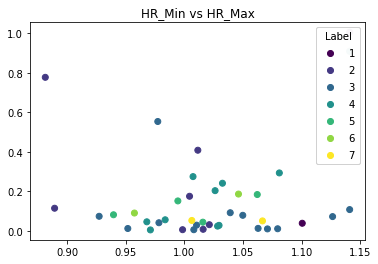

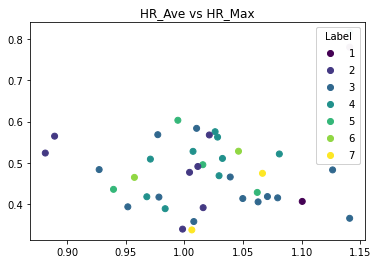

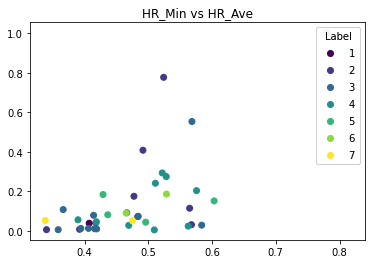

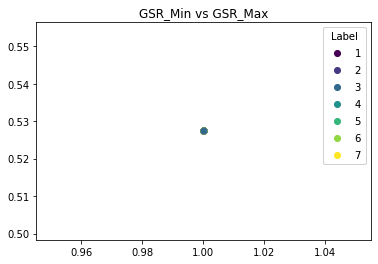

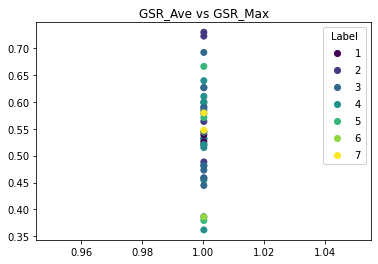

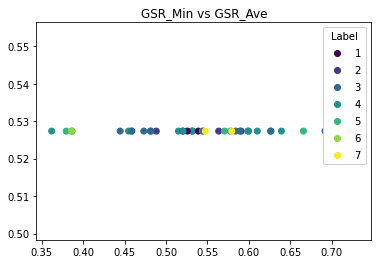

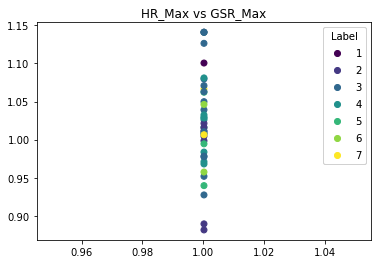

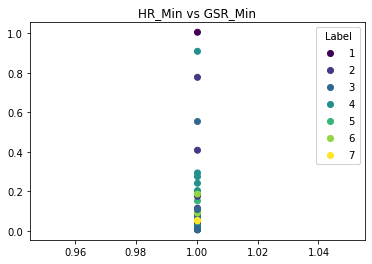

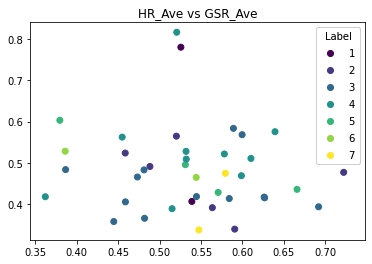

In [217]:
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[0]],stress_df_test[stress_df_test.columns[2]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[0]],stress_df_test[stress_df_test.columns[4]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Ave vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[4]],stress_df_test[stress_df_test.columns[2]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[3]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[5]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("GSR_Ave vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[5]],stress_df_test[stress_df_test.columns[3]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[0]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Max vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[2]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Min vs GSR_Min")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[5]],stress_df_test[stress_df_test.columns[4]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Ave vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

In [234]:
#Testing model

# saved_model_name = "log_model_all.sav"
# clf = pickle.load(open(saved_model_name, 'rb'))

tp = 0
fp = 0
tn = 0
fn = 0

predicted_labels = []
actual_labels = []

for i in range(len(stress_df_test)):
    predicted_label = clf.predict([stress_df_test.iloc[i, 0:6]])[0]
    print(i)
    actual_label = stress_df_test.iloc[i, 6]

    if predicted_label >= 5:
        print("Predicted: Stressed", predicted_label)
        if actual_label >= 5:
            print("Actual: Stressed", actual_label)
            tp += 1
        else:
            print("Actual: Not Stressed", actual_label)  
            fp += 1
            
    else:
        print("Predicted: Not Stressed", predicted_label)
        if actual_label >= 5:
            print("Actual: Stressed", actual_label)
            fn += 1 
        else:
            print("Actual: Not Stressed", actual_label)
            tn += 1
    
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)
    
print("\nTotal:", tp+tn+fp+fn, "\n")

acc = (tp+tn)/(tp+tn+fp+fn)*100
sensitivity = tp/(tp+fn)*100 # true positive rate
specificity = tn/(tn+fp)*100# true negative rate
#precision = tp/(tp+fp)*100

print("TP: {}, TN = {}, FP: {}, FN: {}".format(tp, tn, fp, fn))
print("Accuracy: {}, Sensitivity: {}, Specificity: {}".format(acc, sensitivity, specificity))

0
Predicted: Stressed 6
Actual: Not Stressed 4
1
Predicted: Stressed 6
Actual: Stressed 5
2
Predicted: Stressed 6
Actual: Not Stressed 4
3
Predicted: Stressed 6
Actual: Stressed 5
4
Predicted: Stressed 6
Actual: Not Stressed 4
5
Predicted: Stressed 6
Actual: Not Stressed 3
6
Predicted: Not Stressed 2
Actual: Not Stressed 2
7
Predicted: Not Stressed 4
Actual: Not Stressed 3
8
Predicted: Stressed 6
Actual: Not Stressed 2
9
Predicted: Not Stressed 2
Actual: Not Stressed 3
10
Predicted: Stressed 6
Actual: Not Stressed 2
11
Predicted: Stressed 6
Actual: Stressed 5
12
Predicted: Stressed 6
Actual: Not Stressed 3
13
Predicted: Stressed 6
Actual: Stressed 5
14
Predicted: Not Stressed 4
Actual: Not Stressed 2
15
Predicted: Stressed 6
Actual: Not Stressed 4
16
Predicted: Not Stressed 4
Actual: Not Stressed 2
17
Predicted: Stressed 6
Actual: Not Stressed 4
18
Predicted: Stressed 6
Actual: Not Stressed 2
19
Predicted: Stressed 6
Actual: Not Stressed 4
20
Predicted: Stressed 6
Actual: Not Stressed 

In [235]:
#confusion matrix
cm = metrics.confusion_matrix(actual_labels, predicted_labels)
print(cm)
print(predicted_labels)

[[ 0  0  0  1  0  1  0]
 [ 0  1  0  2  0  4  0]
 [ 0  1  0  2  0 10  0]
 [ 0  0  0  1  0  9  0]
 [ 0  0  0  0  0  4  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  0  0  0  2  0]]
[6, 6, 6, 6, 6, 6, 2, 4, 6, 2, 6, 6, 6, 6, 4, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6]


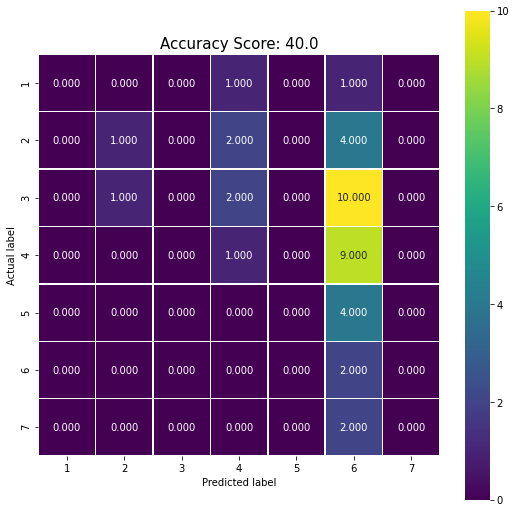

In [236]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis', xticklabels=[1,2,3,4,5,6,7], yticklabels=[1,2,3,4,5,6,7]);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);